### 2023-05-26 nudged coarse run biases

Show time-mean biases in cloud and precipitation in the coarse nudged FV3GFS run.

Nudging target is 10-day PIRE-like ccnorm=True X-SHiELD.

In [1]:
import os
import cftime
import xarray as xr
import intake
import fv3viz
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
from vcm.catalog import catalog as CATALOG
from vcm.fv3.metadata import standardize_fv3_diagnostics
from vcm import convert_timestamps
from vcm import mass_integrate
from dask.diagnostics import ProgressBar

In [2]:
NUDGED_RUN_PATH = 'gs://vcm-ml-experiments/cloud-ml/2023-07-03/cloud-ml-prognostic-run-nudge-to-fine-baseline/fv3gfs_run'
NUDGED_ZARRS = ['sfc_dt_atmos.zarr', 'atmos_dt_atmos.zarr', 'radiative_fluxes.zarr']
COARSENED_FINE_DIAGS_KEY = '10day_c48_PIRE_ccnorm_gfsphysics_15min_may2023'
COARSENED_FINE_RESTARTS_KEY = '10day_c48_PIRE_ccnorm_restarts_as_zarr_may2023'
SECONDS_PER_DAY = 86400.
GRID = CATALOG['grid/c48'].read()
TIME_SLICE = slice(
    cftime.DatetimeJulian(2020, 7, 31, 6, 0, 0),
    cftime.DatetimeJulian(2020, 8, 10, 0, 0, 0),
    4
) # hourly over 10 days
plt.rcParams.update({'font.size': 8})

In [3]:
def get_nudged():
    datasets = [standardize_fv3_diagnostics(xr.open_zarr(os.path.join(NUDGED_RUN_PATH, zarr))) for zarr in NUDGED_ZARRS]
    nudged = xr.merge(datasets)
    nudged = nudged.assign({
        'total_condensate_path': get_total_condensate_path(nudged.VIL, nudged.iw),
        'total_downward_surface_flux': get_total_downward_surface_flux(nudged.total_sky_downward_shortwave_flux_at_surface_python, nudged.total_sky_downward_longwave_flux_at_surface_python)
    })
    return nudged

def get_coarsened_fine():
    coarsened_fine_diags = standardize_fv3_diagnostics(CATALOG[COARSENED_FINE_DIAGS_KEY].to_dask())
    coarsened_fine_restarts = CATALOG[COARSENED_FINE_RESTARTS_KEY].to_dask()
    coarsened_fine_restarts = coarsened_fine_restarts.assign_coords({"time": convert_timestamps(coarsened_fine_restarts.time)})
    coarsened_fine_restarts = standardize_fv3_diagnostics(coarsened_fine_restarts).drop_vars(['ua', 'va', 'zaxis_1', 'yaxis_2', 'xaxis_1'])
    coarsened_fine = xr.merge([coarsened_fine_diags, coarsened_fine_restarts])
    cloud_water_path = mass_integrate(coarsened_fine.liq_wat, coarsened_fine.delp, dim='z')
    ice_water_path = mass_integrate(coarsened_fine.ice_wat, coarsened_fine.delp, dim='z')
    coarsened_fine = coarsened_fine.assign({
        'total_condensate_path': get_total_condensate_path(cloud_water_path, ice_water_path),
        'total_downward_surface_flux': get_total_downward_surface_flux(coarsened_fine.DSWRFsfc, coarsened_fine.DLWRFsfc)
    })
    return coarsened_fine

def get_total_condensate_path(liquid_water_path, ice_water_path):
    total_condensate_path = liquid_water_path + ice_water_path
    return total_condensate_path.assign_attrs({
        'long_name': 'total condensate path', 'units': 'kg/m^2'
    })

def get_total_downward_surface_flux(downward_sw, downward_lw):
    total_rad = downward_sw + downward_lw
    return total_rad.assign_attrs({
        'long_name': 'total sky downward SW + LW flux at surface', 'units': 'W/m^2'
    }) 

In [4]:
coarsened_fine = get_coarsened_fine().sel(time=TIME_SLICE)
coarsened_fine_time_mean = coarsened_fine.mean(dim='time')

In [5]:
nudged = get_nudged().sel(time=TIME_SLICE)
nudged_time_mean = nudged.mean(dim='time')

In [6]:
surface_precipitation_bias = (
    (nudged_time_mean.PRATEsfc - coarsened_fine_time_mean.PRATEsfc) * SECONDS_PER_DAY
).assign_attrs({'long_name': 'bias (coarse - fine)', 'units': 'mm/day'})

surface_precipitation_reference = (
    coarsened_fine_time_mean.PRATEsfc * SECONDS_PER_DAY
).assign_attrs({'long_name': 'surface precipitation rate', 'units': 'mm/day'})

condensate_path_bias = (
    1000 * (nudged_time_mean.total_condensate_path - coarsened_fine_time_mean.total_condensate_path)
).assign_attrs({'long_name': 'bias (coarse - fine)', 'units': 'g/m^2'})

condensate_path_reference = (
    1000 * coarsened_fine_time_mean.total_condensate_path
).assign_attrs({'long_name': 'cloud condensate path', 'units': r'$g/m^2$'})

total_downward_surface_flux_bias = (
    nudged_time_mean.total_downward_surface_flux - coarsened_fine_time_mean.total_downward_surface_flux
).assign_attrs({'long_name': 'bias (coarse - fine)', 'units': 'W/m^2'})

total_downward_surface_flux_reference = (
    coarsened_fine_time_mean.total_downward_surface_flux
).assign_attrs({'long_name': 'downward SW + LW flux at surface', 'units': r'$W/m^2$'})

In [7]:
with ProgressBar():
    time_mean_fields = xr.Dataset({
        'surface_precipitation_bias': surface_precipitation_bias,
        'surface_precipitation_reference': surface_precipitation_reference,
        'condensate_path_bias': condensate_path_bias,
        'condensate_path_reference': condensate_path_reference,
        'total_downward_surface_flux_bias': total_downward_surface_flux_bias,
        'total_downward_surface_flux_reference': total_downward_surface_flux_reference,
    }).compute()

[########################################] | 100% Completed | 525.03 s


In [8]:
def metrics(field: xr.DataArray, weights: xr.DataArray=GRID.area):
    mean = field.weighted(GRID.area).mean().item()
    stdev = weighted_stdev(field - mean, weights)
    return mean, stdev

def weighted_stdev(field: xr.DataArray, weights: xr.DataArray):
    weighted_squares = (field ** 2).weighted(weights).mean()
    return (weighted_squares ** 0.5).item()

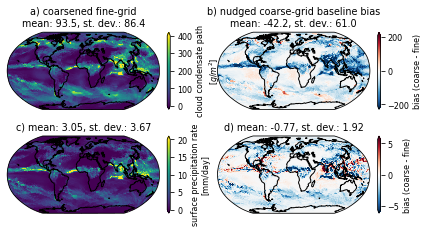

In [10]:
fig, axes = plt.subplots(2, 2, subplot_kw=dict(projection=ccrs.Robinson()))
ax1 = axes[0][0]
fv3viz.plot_cube(
    xr.merge([
        time_mean_fields.condensate_path_reference,
        GRID
    ]),
    'condensate_path_reference',
    vmin=0,
    vmax=400,
    ax=ax1,
    rasterized=True
)
panel_metrics = metrics(time_mean_fields.condensate_path_reference)
ax1.set_title(
    f"a) coarsened fine-grid\nmean: {panel_metrics[0]:0.1f}, st. dev.: {panel_metrics[1]:0.1f}"
)
ax2 = axes[0][1]
fv3viz.plot_cube(
    xr.merge([
        time_mean_fields.condensate_path_bias,
        GRID
    ]),
    'condensate_path_bias',
    cmap='RdBu_r',
    cbar_label='bias (coarse - fine)',
    ax=ax2,
    rasterized=True
)
panel_metrics = metrics(time_mean_fields.condensate_path_bias)
ax2.set_title(
    f"b) nudged coarse-grid baseline bias\nmean: {panel_metrics[0]:0.1f}, st. dev.: {panel_metrics[1]:0.1f}"
)
ax3 = axes[1][0]
fv3viz.plot_cube(
    xr.merge([
        time_mean_fields.surface_precipitation_reference,
        GRID
    ]),
    'surface_precipitation_reference',
    vmin=0,
    vmax=20,
    ax=ax3,
    rasterized=True
)
panel_metrics = metrics(time_mean_fields.surface_precipitation_reference)
ax3.set_title(
    f"c) mean: {panel_metrics[0]:0.2f}, st. dev.: {panel_metrics[1]:0.2f}"
)
ax4 = axes[1][1]
fv3viz.plot_cube(
    xr.merge([
        time_mean_fields.surface_precipitation_bias,
        GRID
    ]),
    'surface_precipitation_bias',
    cmap='RdBu_r',
    cbar_label='bias (coarse - fine)',
    ax=ax4,
    rasterized=True
)
panel_metrics = metrics(time_mean_fields.surface_precipitation_bias)
ax4.set_title(
    f"d) mean: {panel_metrics[0]:0.2f}, st. dev.: {panel_metrics[1]:0.2f}"
)
fig.set_size_inches([6.5, 3.5])
fig.subplots_adjust(wspace=0.38)
fig.savefig('./figures/coarse_nudged_bias.pdf', bbox_inches='tight')